## NDVI

In [60]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
#import skimage
import torch
from torchvision import transforms
import numpy as np
import glob
from skimage import io
import skimage
import matplotlib.pyplot as plt
from Custom_dataloader import *
from Transforms import phantom_segmentation
from Transforms import entropy_mark_transform
from Transforms import hsv_stats_transfrom
from Transforms import lab_stats_transfrom
from Transforms import black_perc_transfrom
import matplotlib.pyplot as plt
def return_rec(bmask, small=True,fn = cv2.contourArea):
    bmask = bmask.astype(np.uint8)
    mass = np.zeros_like(bmask, dtype=np.uint8)
    _,contours ,_ =cv2.findContours(bmask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    rc = []
    for i in contours:
        epsilon = 0.5*cv2.arcLength(i,True)

        if cv2.contourArea(i)>8000:
            vv = cv2.boundingRect(i)
            vva = vv[2]*vv[3]
            if cv2.contourArea(i)/vva >=0.7:
                rc.append(i)
    rc = sorted(rc, key=fn)
    #print(len(rc))
    if small:
        cv2.fillPoly(mass, pts = [rc[0]], color=255)
    else:
        cv2.fillPoly(mass, pts = [rc[-1]], color=255)
    _,yy,_,hy = cv2.boundingRect(mass)
    
    return mass.astype(np.bool_), yy, hy

def get_clothe_masks(img):
    b_mask = ((img[:, :, 0]<20) & (img[:, :, 1]<20) & (img[:, :, 2]<20))
    b_mask, yb, hb = return_rec(b_mask)
    g_mask = (abs(img[:,:,2]-img[:,:,0])<14) & (img[:,:,2]>45)
    g_mask, yg, hg = return_rec(g_mask)
    y = min(yb, yg)
    h = max(hb, hg)
    ra = img.copy()
    ra[y+h+100::,:,2]=0
    ra[max(y-100,0)::-1,:,2]=0
    #plt.imshow(ra[:,:,::-1])
    r_mask = ((ra[:, :, 2]>105) & (ra[:, :, 1]<60))
    r_mask,_,_ = return_rec(r_mask, small=False)
    return r_mask, g_mask, b_mask

def reg(rgb_img, nir_img):
    ## Registration
    rgb_ = cv2.resize(rgb_img, (4000, 3000))
    rgb_ = cv2.cvtColor(rgb_, cv2.COLOR_BGR2GRAY) 
    
    nir_ = cv2.resize(nir_img, (4000, 3000))
    nir_ = nir_[:, :, 0]
    
    #akaze = cv2.xfeatures2d.SIFT_create()
    akaze = cv2.xfeatures2d.SURF_create() #python version mismatch
    kp1, des1 = akaze.detectAndCompute(rgb_, None)
    kp2, des2 = akaze.detectAndCompute(nir_, None)
    
    bf = cv2.BFMatcher(cv2.NORM_L1)
    matches = bf.knnMatch(des1, des2, k = 2)
    
    good_matches = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good_matches.append([m])
    
    ref_matched_kpts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches])
    sensed_matched_kpts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches])
    
    H, status = cv2.findHomography(sensed_matched_kpts, ref_matched_kpts, cv2.RANSAC,80.0)
    nir_img = cv2.warpPerspective(nir_img, H, (rgb_img.shape[1], rgb_img.shape[0]))
    return nir_img
def compute_ndvi(rgb_img, nir_img, mask, statistic=True):
    ## Registration
    rgb_ = cv2.resize(rgb_img, (4000, 3000))
    rgb_ = cv2.cvtColor(rgb_, cv2.COLOR_BGR2GRAY) 
    
    nir_ = cv2.resize(nir_img, (4000, 3000))
    nir_ = nir_[:, :, 0]
    
    akaze = cv2.xfeatures2d.SURF_create()
    
    kp1, des1 = akaze.detectAndCompute(rgb_, None)
    kp2, des2 = akaze.detectAndCompute(nir_, None)
    
    bf = cv2.BFMatcher(cv2.NORM_L1)
    matches = bf.knnMatch(des1, des2, k = 2)
    
    good_matches = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good_matches.append([m])
    
    ref_matched_kpts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches])
    sensed_matched_kpts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches])
    
    H, status = cv2.findHomography(sensed_matched_kpts, ref_matched_kpts, cv2.RANSAC,80.0)
    nir_img = cv2.warpPerspective(nir_img, H, (rgb_img.shape[1], rgb_img.shape[0]))
    
    ##Adjustment
    
    #====================SKIMAGE VERSION
    #rgb_img = rgb_img[::-1]
    #nir_img = nir_img[::-1]
    #=================================
    rgb_img = rgb_img.astype(np.float64)
    nir_img = nir_img.astype(np.float64)
    RR = np.array([[1.377, -0.182, -0.061],
          [-0.199, 1.420, -0.329],
          [-0.034, -0.110, 1.150]])
    RN = np.array([[-0.956, 0., 1.],
          [2.426, 0., -0.341],
          [0., 1., 0.]])
    maskn = ((nir_img[:,:,0]!=0)&(nir_img[:,:,1]!=0)&(nir_img[:,:,2]!=0)).astype(np.bool_)
    rgb_img = np.matmul(rgb_img, RR.T)
    nir_img = np.matmul(nir_img, RN.T)
    NDVI = (2.7*nir_img[:, :, 1]-rgb_img[:, :, 2])/(2.7*nir_img[:, :, 1]+rgb_img[:, :, 2])
    mask &= maskn
    ##Mean STD calculation
    #plt.imshow(NDVI)
    
    if not(statistic):
        #imout = np.zeros_like(NDVI)
        #imout[mask] = NDVI[mask]
        #return imout
        return cv2.bitwise_and(NDVI, NDVI, mask=mask)
    else:
        mask = mask.astype(bool)
        mndvi = NDVI[mask]
        return [mndvi.mean(), mndvi.std()]

In [63]:
from os import stat
import matplotlib.pyplot as plt

class ndvi_desc():
    """Compute NDVI from RGB and NIR image 
    
    Args:
        statistic(boolean): Return either mean and std
        or masked NDVI image
        
    output:
        NDVI mean and std

    """

    def __init__(self, statistic_ = False):
        self.statistic = statistic_

    def __call__(self, sample):
        rgb, nir, mask, landmarks = sample['SenteraRGB'],\
            sample['SenteraNIR'], sample['SenteraMASK'],\
                 sample['landmarks']
        mask.astype(np.bool_)
        rgb = rgb[::-1]
        nir = nir[::-1]
        
        if self.statistic:
            mean, std = compute_ndvi(rgb,nir, mask)
            return{'SenteraNDVI': {'mean': mean, 'std': std}, 'landmarks': landmarks, 'Date':sample['Date']}
        else:
            ndvi = compute_ndvi(rgb,nir, mask, statistic=False)
            return{'SenteraNDVI': ndvi, 'landmarks': landmarks, 'Date':sample['Date']}

In [64]:
from os import stat
import matplotlib.pyplot as plt

class registration():
    """Compute NDVI from RGB and NIR image 
    
    Args:
        statistic(boolean): Return either mean and std
        or masked NDVI image
        
    output:
        NDVI mean and std

    """

    def __init__(self):
        pass

    def __call__(self, sample):
        rgb, nir, landmarks = sample['SenteraRGB'],\
            sample['SenteraNIR'], sample['landmarks']
        
        #rgb = rgb[::-1]
        #nir = nir[::-1]
        
        
        return {'SenteraREG': reg(rgb, nir), 'landmarks': landmarks, 'Date':sample['Date']}

In [65]:

DB="/run/user/1000/gvfs/afp-volume:host=MyCloudPR4100.local,user=admin,volume=Paltas_DataBase/Data_Base_v2"
#d_t=transforms.Compose([registration()])
d_t = transforms.Compose([ndvi_desc(statistic_=False)])
d_b = transforms.Compose([registration()])

In [27]:
#tdatab=Dataset_direct(root_dir=DB,ImType=['PhantomRGB'],Trees_fil='*',Intersec=False)
datab=Dataset_direct(root_dir=DB,ImType=['SenteraRGB', 'SenteraNIR', 'SenteraMASK'],Intersec=False, transform=d_t)
dataa=Dataset_direct(root_dir=DB,ImType=['SenteraRGB', 'SenteraNIR'],Intersec=False, transform=d_b)
datac=Dataset_direct(root_dir=DB,ImType=['SenteraMASK', 'SenteraRGB'],Intersec=False, transform=None)

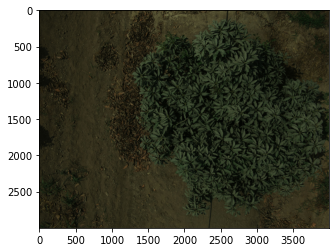

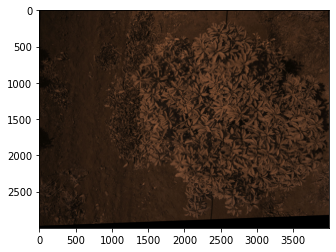

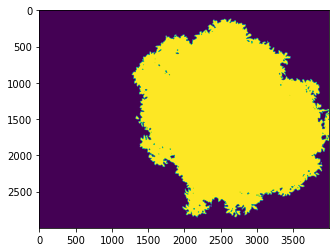

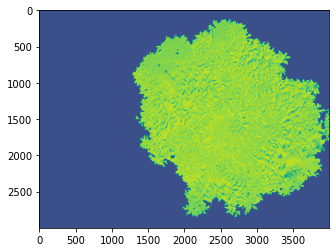

In [36]:
N = 370
plt.figure()
plt.imshow(datac[N]['SenteraRGB'])
plt.figure()
plt.imshow(dataa[N]['SenteraREG'])
plt.figure()
plt.imshow(datac[N]['SenteraMASK'])
plt.figure()
plt.imshow(datab[N]['SenteraNDVI'])

## TEXTURES

In [68]:
import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops
from skimage import data
for i in range(3):
    a = datab[5*i]['SenteraNDVI']
    a = ((a+1)*255/2).astype(np.uint8)
    glcm = greycomatrix(a, distances=[15, 30, 50], angles=[0, np.pi/2], levels=256)
    print(greycoprops(glcm, 'dissimilarity'))



[[4.27793927 4.21406064]
 [5.89415835 5.92885471]
 [6.98587662 7.12972729]]
[[3.80029895 3.60580729]
 [4.90972964 4.92117003]
 [5.73478565 5.86105729]]
[[3.0827724  2.87577605]
 [4.48013669 4.43138754]
 [5.57712692 5.59461254]]
